In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.titlesize"] = 18
plt.rcParams["axes.titlesize"] = 18

In [4]:
RANDOM_SEED = 666
np.random.seed(RANDOM_SEED)

# Data Investigation

In [5]:
bikes = pd.read_csv("../data/jay_st_bikes.csv")
bikes.head()

,name,num_bikes_available,last_reported
0,Jay St & Tech Pl,0,86400
1,Jay St & Tech Pl,0,86400
2,Jay St & Tech Pl,0,86400
3,Jay St & Tech Pl,0,86400
4,Jay St & Tech Pl,0,86400


In [6]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732532 entries, 0 to 732531
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   name                 732532 non-null  object
 1   num_bikes_available  732532 non-null  int64 
 2   last_reported        732532 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 16.8+ MB


`last_reported` corresponds to the last time the station reported its info to the Citi Bike API. We see here that it's an integer. It is in "unix time" corresponding to the number of seconds since January 1st, 1970 at 00:00:00.

In [7]:
pd.to_datetime(bikes["last_reported"], unit="s")

0        1970-01-02 00:00:00
1        1970-01-02 00:00:00
2        1970-01-02 00:00:00
3        1970-01-02 00:00:00
4        1970-01-02 00:00:00
                 ...        
732527   2022-10-14 02:12:04
732528   2022-10-14 02:12:04
732529   2022-10-14 02:12:04
732530   2022-10-14 02:12:04
732531   2022-10-14 02:12:04
Name: last_reported, Length: 732532, dtype: datetime64[ns]

Actually, this is in UTC time, and we should make sure Pandas knows this.

In [8]:
pd.to_datetime(bikes["last_reported"], unit="s", origin="unix", utc=True)

0        1970-01-02 00:00:00+00:00
1        1970-01-02 00:00:00+00:00
2        1970-01-02 00:00:00+00:00
3        1970-01-02 00:00:00+00:00
4        1970-01-02 00:00:00+00:00
                    ...           
732527   2022-10-14 02:12:04+00:00
732528   2022-10-14 02:12:04+00:00
732529   2022-10-14 02:12:04+00:00
732530   2022-10-14 02:12:04+00:00
732531   2022-10-14 02:12:04+00:00
Name: last_reported, Length: 732532, dtype: datetime64[ns, UTC]

And actually, let's convert it to EST.

In [9]:
bikes["last_reported"] = pd.to_datetime(
    bikes["last_reported"], unit="s", origin="unix", utc=True
).dt.tz_convert("US/Eastern")
bikes["last_reported"]

0        1970-01-01 19:00:00-05:00
1        1970-01-01 19:00:00-05:00
2        1970-01-01 19:00:00-05:00
3        1970-01-01 19:00:00-05:00
4        1970-01-01 19:00:00-05:00
                    ...           
732527   2022-10-13 22:12:04-04:00
732528   2022-10-13 22:12:04-04:00
732529   2022-10-13 22:12:04-04:00
732530   2022-10-13 22:12:04-04:00
732531   2022-10-13 22:12:04-04:00
Name: last_reported, Length: 732532, dtype: datetime64[ns, US/Eastern]

Ok better, but why does it start at 1970?

These are null values. Let's throw them out. 

The nice thing about having our data in proper datetime format is that we can reference it with strings in pandas.

In [10]:
bikes = bikes[bikes["last_reported"] > "1971"]

In [11]:
bikes

,name,num_bikes_available,last_reported
220,Jay St & Tech Pl,30,2019-12-31 17:33:10-05:00
221,Jay St & Tech Pl,30,2019-12-31 17:33:10-05:00
222,Jay St & Tech Pl,30,2019-12-31 17:33:10-05:00
223,Jay St & Tech Pl,30,2019-12-31 17:33:10-05:00
224,Jay St & Tech Pl,30,2019-12-31 17:33:10-05:00
...,...,...,...
732527,Jay St & Tech Pl,25,2022-10-13 22:12:04-04:00
732528,Jay St & Tech Pl,25,2022-10-13 22:12:04-04:00
732529,Jay St & Tech Pl,25,2022-10-13 22:12:04-04:00
732530,Jay St & Tech Pl,25,2022-10-13 22:12:04-04:00


In [13]:
# Drop duplicates for rows where the same `last_reported` time was reported for multiple API calls.
bikes = bikes.drop_duplicates()

Looks like the data goes from basically 2020-yesterday. Let's save some space by dropping the `name` field. We'll also set the timestamp field as the index.

In [14]:
bikes = bikes.set_index("last_reported")["num_bikes_available"]

In [15]:
bikes = bikes.sort_index()

In [16]:
bikes.head()

last_reported
2019-12-31 17:33:10-05:00    30
2019-12-31 19:24:00-05:00    32
2019-12-31 19:25:36-05:00    35
2019-12-31 19:27:46-05:00    34
2019-12-31 19:55:38-05:00    33
Name: num_bikes_available, dtype: int64

We can now index by time.

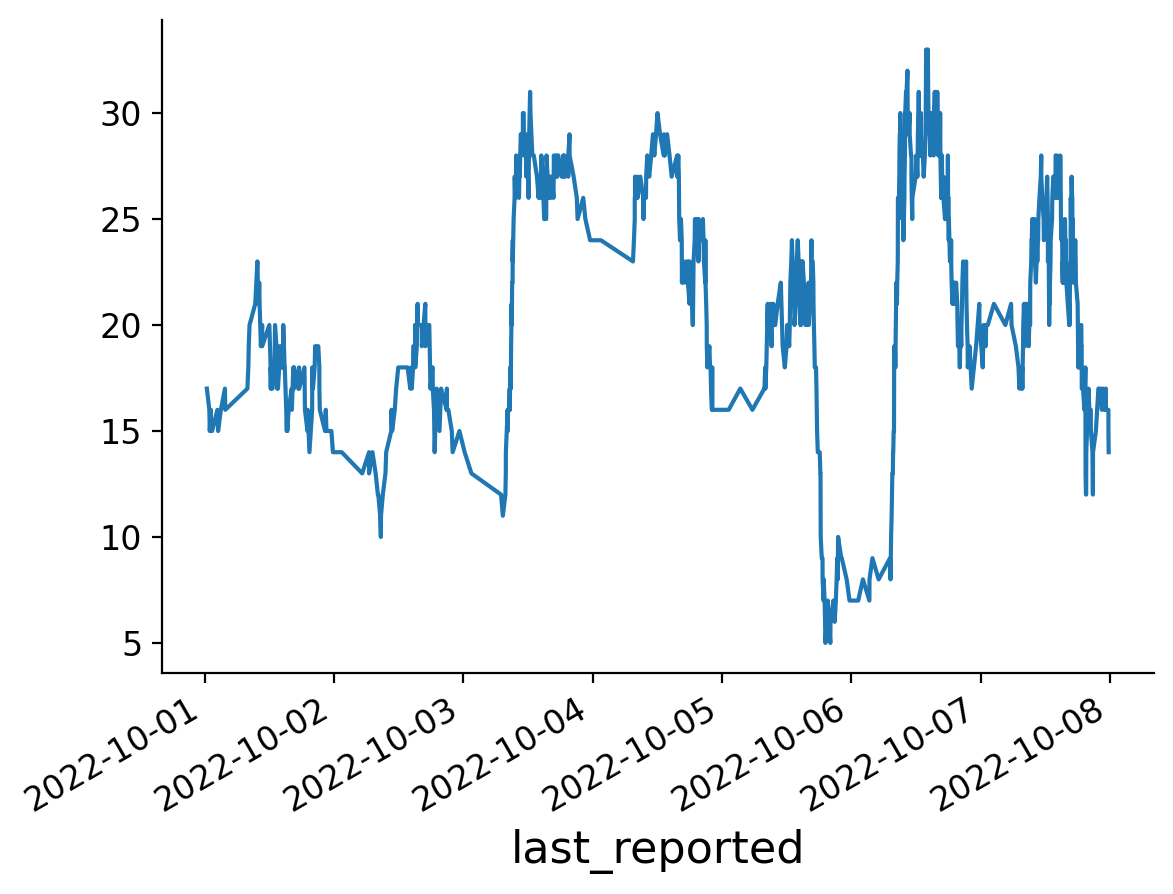

In [19]:
bikes.loc["2022-10-01":"2022-10-07"].plot()
None

# Basic ML

To peform ML, it helps to resample the data so that each point is evenly spaced in time.

In [20]:
# Resample so that the index corresponds to 5 minute increments.
# We pick .last() so that we are not leaking future information into the
# past.
SAMPLE_MINUTES = 5
bikes = bikes.resample(f"{SAMPLE_MINUTES}T").last()

# Finally, we fill any missing data after the resampling using the most
# recently known data.
bikes = bikes.fillna(method="ffill")

In [21]:
bikes.head()

last_reported
2019-12-31 17:30:00-05:00    30.0
2019-12-31 17:35:00-05:00    30.0
2019-12-31 17:40:00-05:00    30.0
2019-12-31 17:45:00-05:00    30.0
2019-12-31 17:50:00-05:00    30.0
Freq: 5T, Name: num_bikes_available, dtype: float64

Now, pick out some training and test data and create `X` and `y` matrices. We'll use all of 2021 as our training data and all data (so far) in 2022 for our test data.

In [22]:
train_start = bikes.index.get_loc("2021-01-01 00:00:00-04:00")
train_end = bikes.index.get_loc("2022-01-01 00:00:00-04:00")

test_start = bikes.index.get_loc("2022-01-01 00:00:00-04:00")
test_end = bikes.index.get_loc("2022-10-13 00:00:00-04:00")

In [25]:
def create_lag_features(y, start_index, end_index, num_lags):
    X = []
    # At each point in y between start and end, collect the prior `num_lags`
    # values of y to use as lag features.
    for idx in range(start_index, end_index):
        # We offset by 1 so that we are grabbing everything up until the
        # current value of y.
        X.append(y[(idx - 1) - num_lags : idx - 1])
    return np.vstack(X)

Split into training and test sets. We'll use one day's worth of data for the lag features.

In [26]:
# One day's worth of lags.
NUM_LAGS = int(60 / SAMPLE_MINUTES * 24)

y = bikes.values

y_train = y[train_start:train_end]
y_test = y[test_start:test_end]

X_train = create_lag_features(y, train_start, train_end, NUM_LAGS)
X_test = create_lag_features(y, test_start, test_end, NUM_LAGS)

In [27]:
X_train.shape

(105120, 288)

In [28]:
X_test.shape

(82080, 288)

Now, let's train a simple linear regression model.

In [29]:
from sklearn.linear_model import LinearRegression

In [30]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [31]:
y_pred = model.predict(X_test)

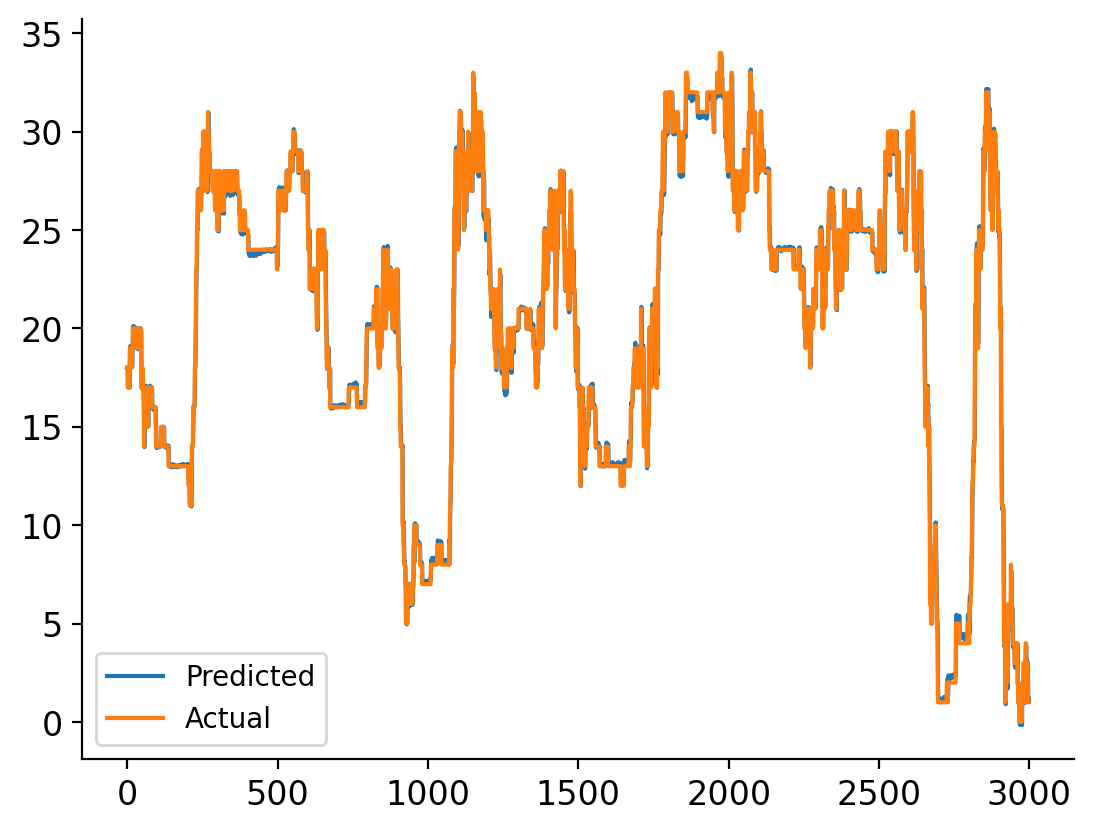

In [32]:
fig, ax = plt.subplots()
start = -3_000
ax.plot(y_pred[start:], label="Predicted")
ax.plot(y_test[start - 1 : -1], label="Actual")
ax.legend()
None

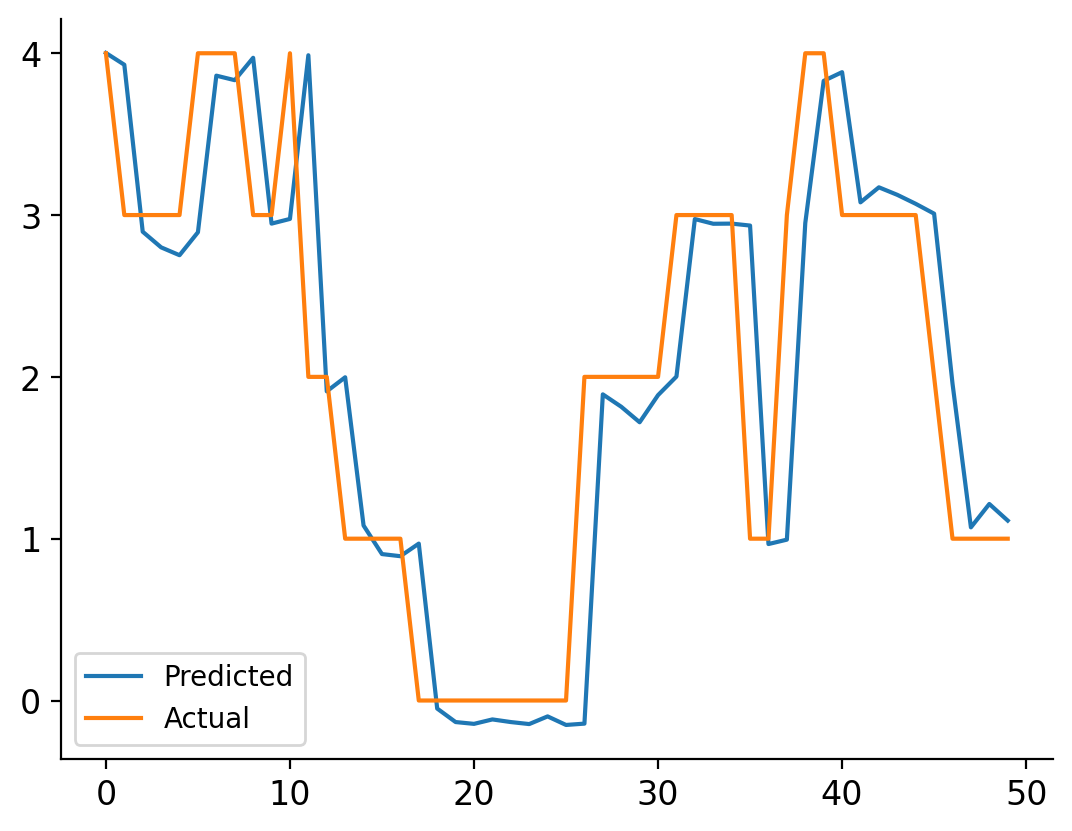

In [33]:
fig, ax = plt.subplots()
start = -50
ax.plot(y_pred[start:], label="Predicted")
ax.plot(y_test[start - 1 : -1], label="Actual")
ax.legend()
None

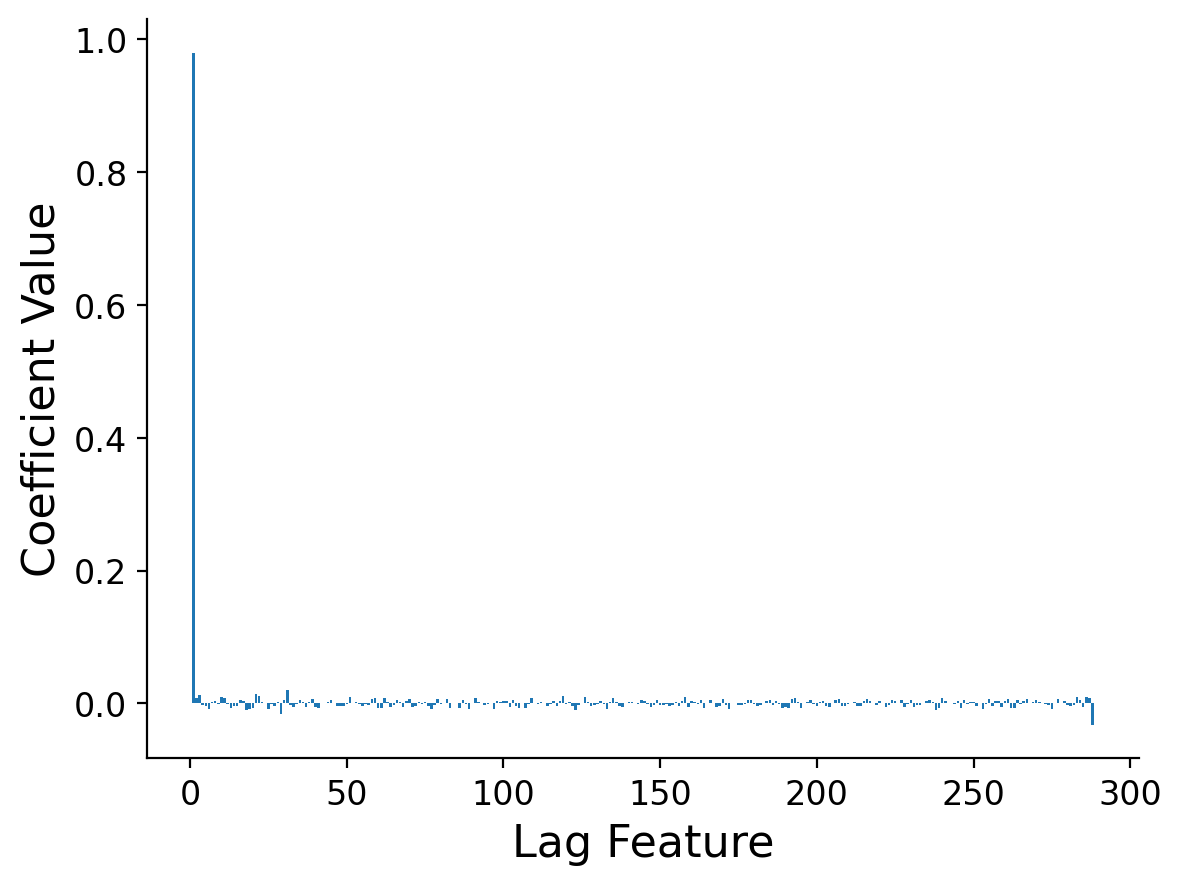

In [34]:
fig, ax = plt.subplots()
ax.bar(list(range(1, len(model.coef_) + 1)[::-1]), model.coef_)
ax.set_ylabel("Coefficient Value")
ax.set_xlabel("Lag Feature")
None

Either ironically or unsurprisingly, you can get pretty good performance!

In [35]:
from sklearn.metrics import mean_absolute_error, r2_score

In [36]:
print(f"Mean Absolute Error = {mean_absolute_error(y_test, y_pred):.3}")
print(f"R2 = {r2_score(y_test, y_pred):.3}")

Mean Absolute Error = 0.676
R2 = 0.968


Instead of predicting 5 minutes into the future, let's predict 60 minutes into the future

In [37]:
prediction_minutes = 60
prediction_steps = int(prediction_minutes / SAMPLE_MINUTES - 1)

y_train = y[train_start + prediction_steps : train_end + prediction_steps]
y_test = y[test_start + prediction_steps : test_end + prediction_steps]

X_train = create_lag_features(y, train_start, train_end, NUM_LAGS)
X_test = create_lag_features(y, test_start, test_end, NUM_LAGS)

In [38]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [39]:
y_pred = model.predict(X_test)

While it may look good, it's mostly similar to before.

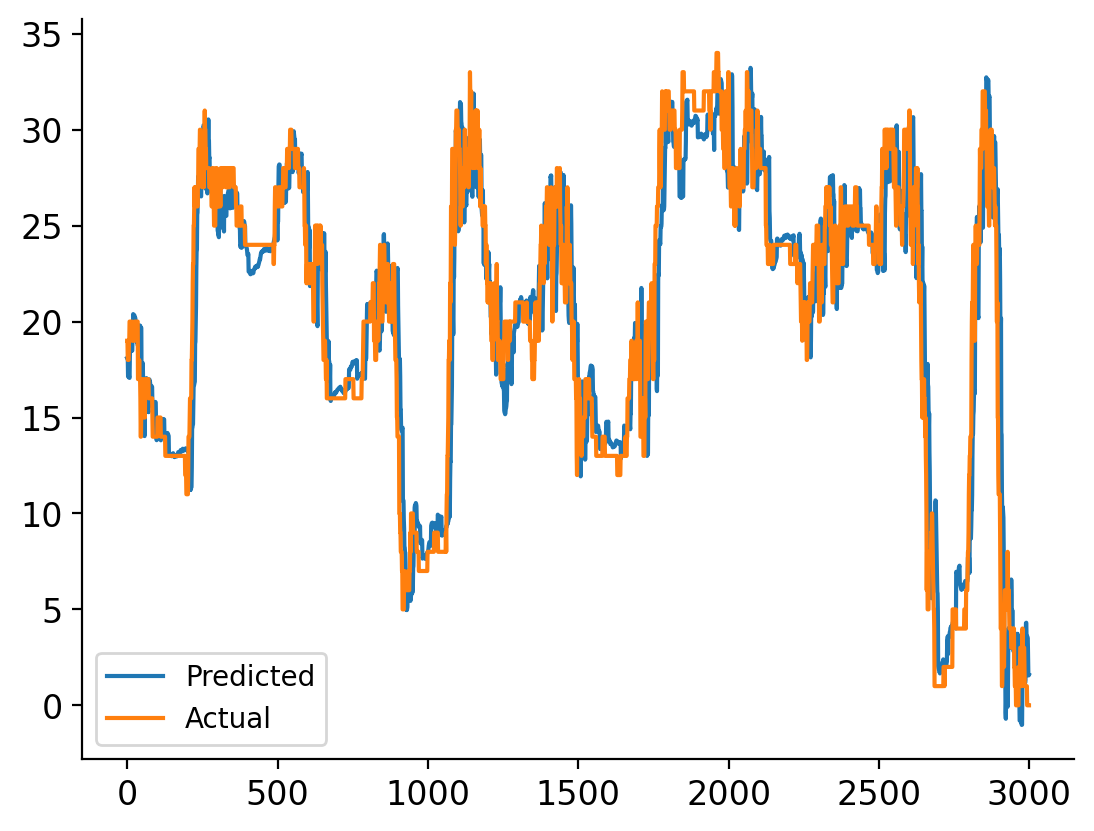

In [40]:
fig, ax = plt.subplots()
start = -3_000
ax.plot(y_pred[start:], label="Predicted")
ax.plot(y_test[start - 1 : -1], label="Actual")
ax.legend()
None

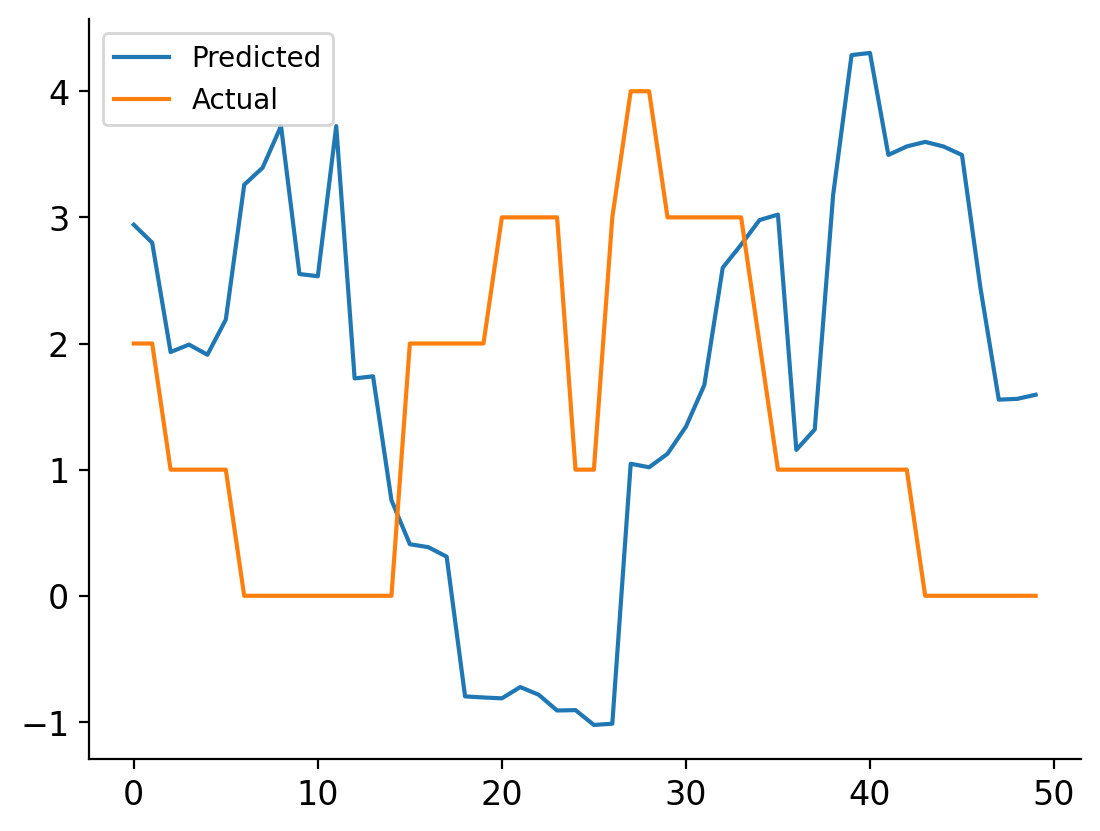

In [41]:
fig, ax = plt.subplots()
start = -50
ax.plot(y_pred[start:], label="Predicted")
ax.plot(y_test[start - 1 : -1], label="Actual")
ax.legend()
None

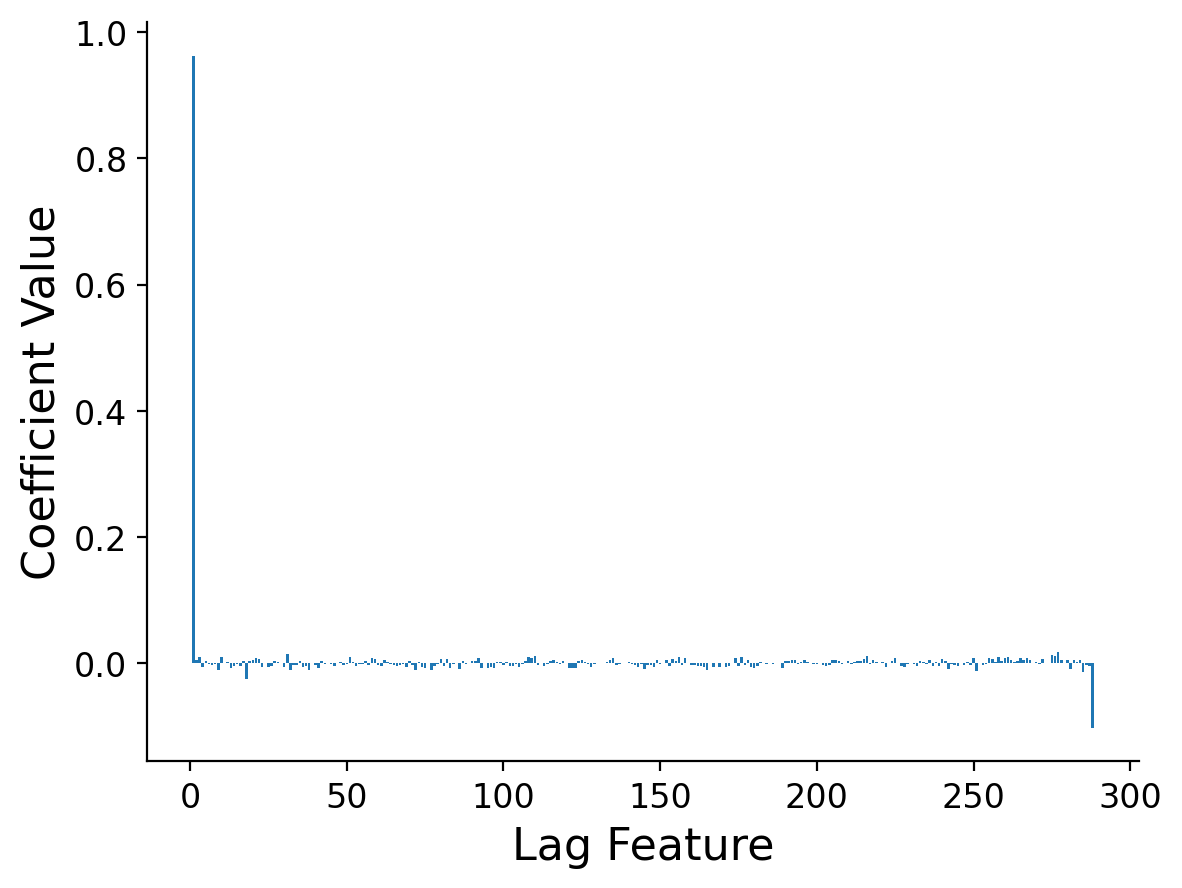

In [42]:
fig, ax = plt.subplots()
ax.bar(list(range(1, len(model.coef_) + 1)[::-1]), model.coef_)
ax.set_ylabel("Coefficient Value")
ax.set_xlabel("Lag Feature")
None

In [43]:
print(f"Mean Absolute Error = {mean_absolute_error(y_test, y_pred):.3}")
print(f"R2 = {r2_score(y_test, y_pred):.3}")

Mean Absolute Error = 2.04
R2 = 0.828


Lastly, let's program up a quick forecast

In [44]:
forecast = []
forecast_start = -2500
forecast_steps = int(120 / SAMPLE_MINUTES)

X_forecast = X_test[forecast_start, :].reshape(1, -1)

for step in range(forecast_steps):
    forecast.append(model.predict(X_forecast)[0])
    X_forecast = np.roll(X_forecast, -1, axis=1)
    X_forecast[:, -1] = forecast[-1]

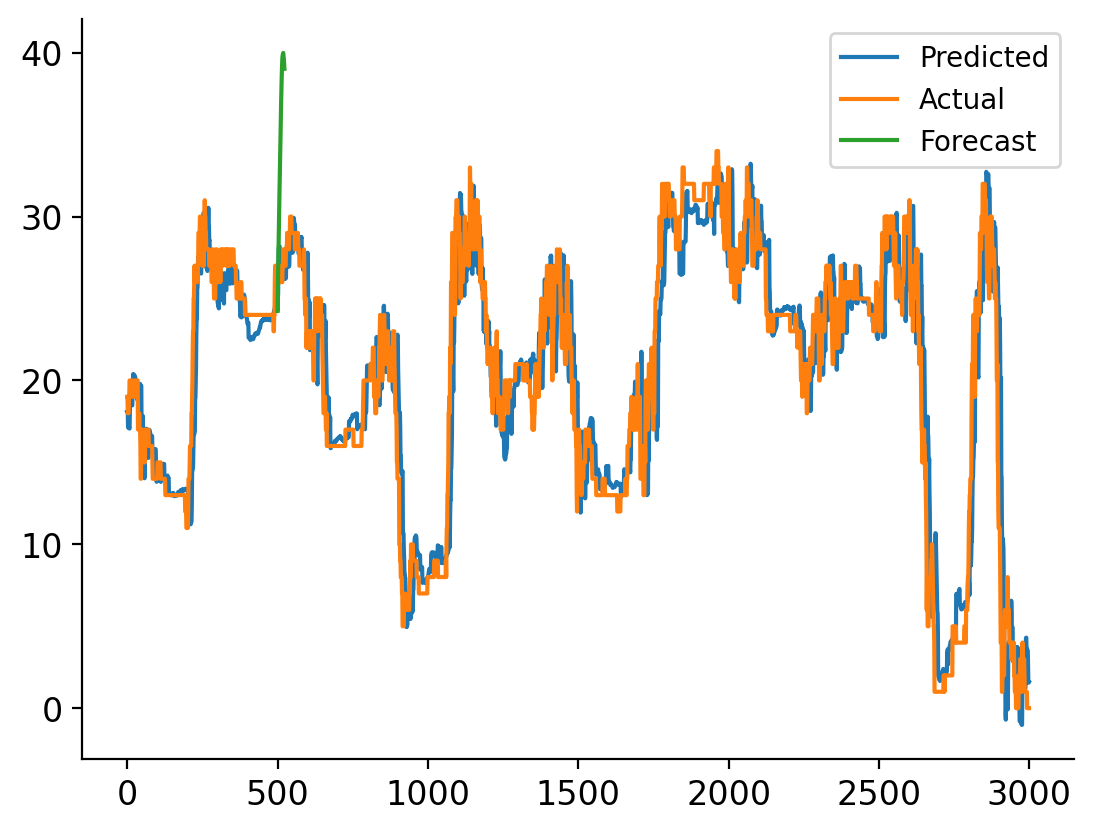

In [45]:
fig, ax = plt.subplots()
start = -3_000
ax.plot(y_pred[start:], label="Predicted")
ax.plot(y_test[start - 1 : -1], label="Actual")
ax.plot(
    np.arange(forecast_start - start, forecast_start - start + forecast_steps),
    forecast,
    label="Forecast",
)
ax.legend()
None